# Notebook "Statistical learning with Lipschitz and convex loss functions"

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

from numpy.linalg import norm
from numpy.random import multivariate_normal
from numpy.random import randn
from sklearn import linear_model, metrics

%matplotlib inline

Let us assume that $t$ is a linear function of features: $t = \sum_{i=1}^p \beta_j X_j$. Let us define $h_{\beta}(X) = \frac{1}{1+\exp(-\beta^TX)}$. Then we have $\mathbb{P}(Y_i = 1 | X_i = x_i) = h_{\beta}(x_i)$. This is equivalent to say that $Y|X=x \sim Bern(h_{\beta}(x))$ Such a model allowed to have:
$$ 
    \log \frac{\mathbb{P}(Y=1|X=x)}{\mathbb{P}(Y=-1|X=x)} = \sum_{j=1}^p \beta_j x_j
$$
Thus, it is a generalized linear model. 

## No noise: 
$$ 
    \log \frac{\mathbb{P}(Y=1|X=x)}{\mathbb{P}(Y=-1|X=x)} = \sum_{j=1}^p \beta_j x_j
$$

In [2]:
def sigmoid(t):
    """Sigmoid function"""
    return(1/(1+np.exp(-t)))

def simu_logistic(coeffs,n_samples):
    """Simulation of a logistic model with Normal features"""

    X = np.random.normal(size = (n_samples,len(coeffs)))
    h_beta = sigmoid(np.dot(X,coeffs)) 
    Y = np.random.binomial(1, h_beta, size=n_samples) 
    return(((2*Y)-1),X)

X shape:  (1000, 50)
y shape:  (1000,)
X_train shape:  (800, 50)
y_train shape:  (800,)
X_test shape:  (200, 50)
y_test shape:  (200,)


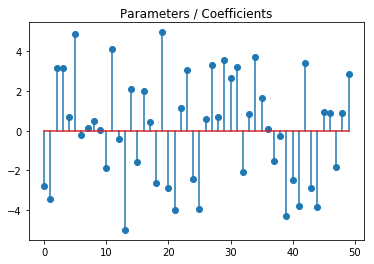

In [3]:
n_sample = 1000
p = 50
coeffs = 10*np.random.uniform(size = p) - 5

y, X = simu_logistic(coeffs,n_sample)
print("X shape: ",X.shape)
print("y shape: ",y.shape)

n_train = int(0.8*n_sample)
X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

plt.stem(coeffs)
plt.title("Parameters / Coefficients")



In [4]:
n_train = int(0.8*n_sample)
X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]

In [5]:
from sklearn import linear_model, metrics

log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)

score = metrics.accuracy_score(y_test,predictions)
print('Accuracy:', round(score,4)*100)

Accuracy: 93.5


In [6]:
def lip_logreg(X,n_samples):
    """Lipschitz constant for logistic loss"""
    return 1. / (4 * n_samples) * np.linalg.norm(np.dot(np.transpose(X), X), 2)

def clever_loss(x):
    '''Function that allows to compute the loss even if x is large'''
    if x < 0: 
        return(np.log(1+np.exp(x)))
    else:
        return(x + np.log(1+np.exp(-x)))

def loss_block(X, y, t):
    """Logistic loss on data data idx"""
    'We have computation issues because of the exponential'
    return 1. / X.shape[0] * sum([clever_loss(- y[i] * np.dot(np.transpose(X[i,]), t))
                                 for i in range(X.shape[0])]) 

def excess_loss(X, y, t, t_star):
    """Excess loss on data data idx whre t_prime is the Oracle"""
    return loss_block(X, y, t)- loss_block(X , y, t_star)

def grad_logreg(X, y, t):
    """Logistic gradient"""
    return - 1 / X.shape[0] *  sum([y[i] / (1. + np.exp(y[i] * np.dot(np.transpose(X[i,]), t))) * np.transpose(X[i,])
                  for i in range(X.shape[0])  if (y[i] * np.dot(np.transpose(X[i,]), t)) < 7*np.log(10) ])


def partition_block(K,N):
    """ Attribute to each data a block
    If -1 then it belongs to any block """
    idx_block = np.zeros(N)
    idx_block[np.arange(N % K)] = np.repeat(-1,N % K)
    idx_block[np.arange(N % K , N)] = np.repeat(np.arange(K),int(N/K))
    np.random.shuffle(idx_block)
    return(idx_block)

def median_block(X, y, t_prime, t, K, N):
    """
    Attribute to each data a block
    Return data in the median block (where the excess loss is median)
    """
    exc_loss = np.zeros(K)
    partition = partition_block(K, N)
    for j in np.arange(K):
        idx_block = np.where(partition == j)[0]
        exc_loss[j] = excess_loss(X[idx_block,:], y[idx_block], t, t_prime)
    median_block = np.argsort(exc_loss)[int(K/2)]
    return X[np.where(partition == median_block)[0],], y[np.where(partition == median_block)[0]]

In [7]:
def MOM_ista(X, y, t0, t0_prime, step, K, n_iter=50, t_true = coeffs, verbose=True):
    """Alternating Gradient Descent Algorithm"""
    
    t = t0.copy()
    t_prime = t0_prime.copy()
      
    n_samples, n_features = X.shape
    
    errors = np.zeros(n_iter)
    objectives = np.zeros(n_iter)
    
    errors[0] = norm(t - t_true) / norm(t_true)
    X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
    objectives[0] = excess_loss(X_block, y_block, t, t_true)
    if verbose:
        print ("Lauching MOM solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
        
    for k in range(1, n_iter ):
        
        
        "Ascent in t_prime"
        X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
        
        t_prime = t_prime - step * grad_logreg(X_block, y_block, t_prime)
        
        "Descent in t"
        X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
        
        t = t - step * grad_logreg(X_block, y_block, t)
        
        
        "Compute the error and the objective"
        
        errors[k] = norm(t - t_true) / norm(t_true)
        objectives[k] = excess_loss(X_block, y_block, t, t_true)

        if k % 20 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % objectives[k]).rjust(8), 
                              ("%.2e" % errors[k]).rjust(8)]))
            
    return t, t_prime, objectives, errors


def prediction_mom(coeff, X_test, y_test,verbose = True):
    proba = 1/(1+np.exp(-np.dot(X_test, coeff)))
    predictions = np.sign(2*proba-1)
    score = metrics.accuracy_score(y_test,predictions)
    if verbose:
        print("Accuracy for MOM Logistic regression: ", score)
    return(score)

In [8]:
t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 100
step = 1. / lip_logreg(X,X_train.shape[0])
K = 50


tmps1=time.clock()
mom_ista = MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=True)
tmps2=time.clock()

print("Temps d'execution MOM ISTA :", tmps2-tmps1)

Lauching MOM solver...
   it    |   obj    |   err   
      20 | -7.28e-02 | 7.20e-01
      40 | 1.15e-02 | 6.57e-01
      60 | 5.82e-03 | 6.15e-01
      80 | 1.59e-02 | 5.79e-01
Temps d'execution MOM ISTA : 2.601093


Accuracy for MOM Logistic regression:  0.91


0.91000000000000003

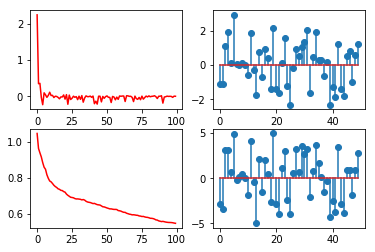

In [9]:
f, axarr = plt.subplots(2,2)
plt.figure(figsize=(8,10))
axarr[0,0].plot(mom_ista[2], 'r-', label= 'ISTA')
axarr[1,0].plot(mom_ista[3], 'r-', label= 'ISTA')
axarr[0,1].stem(mom_ista[0])
axarr[1,1].stem(coeffs)

prediction_mom(mom_ista[0],X_test,y_test)

### Comments : 

    - It is possible to accelerate the algorithm and more precisely the computation of the median block. I am doing a loop which is far from being optimal.
    - We can use faster algorithm such as the accelerated gradient descent from Nesterov. 

## Simulation with noise: 

$$ 
    \log \frac{\mathbb{P}(Y=1|X=x)}{\mathbb{P}(Y=-1|X=x)} = \sum_{j=1}^p \beta_j x_j + \xi
$$
where $\xi$ denote the noise of the problem and is supposed to be distributed as a strandard gaussian variable.

In [10]:
def simu_noisy_logistic(coeffs,n_samples):
    """Simulation of a logistic model with Normal features. Noise : centered with variance 1 normal"""

    X = np.random.normal(size = (n_samples,len(coeffs)))
    noise = np.random.normal(0,1,n_samples)
    h_beta = sigmoid(np.dot(X,coeffs)+ noise) 
    Y = np.random.binomial(1, h_beta, size=n_samples) 
    return(((2*Y)-1),X)

n_sample = 1000
p = 50
coeffs = 10*np.random.uniform(size = p) - 5

y, X = simu_noisy_logistic(coeffs,n_sample)

n_train = int(0.8*n_sample)
X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]


log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)

score = metrics.accuracy_score(y_test,predictions)
print('Accuracy sklearn:', round(score,4)*100)

t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 60
step = 1. / lip_logreg(X,X_train.shape[0])
K = 50

mom_ista = MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=True)

prediction_mom(mom_ista[0],X_test,y_test)

Accuracy sklearn: 92.5
Lauching MOM solver...
   it    |   obj    |   err   
      20 | -4.18e-02 | 7.02e-01
      40 | -2.99e-02 | 6.41e-01
Accuracy for MOM Logistic regression:  0.865


0.86499999999999999

##  Performances with Outliers : 

We add an increasing number of outliers such that for any outlier $X \sim \mathcal T(5)$ and $\xi \sim \mathcal{LN}(0,1)$. A cross validation is performed to have the optmimal number of blocks $K$.

In [ ]:
def simu_outliers(coeffs,n_outliers):
    """Simulation of a logistic model with Normal features. Noise : centered with variance 1 normal"""

    X =  X = np.random.lognormal(0,1,(n_outliers, len(n_features)))
    noise = np.random.standard_t(5, size=n_outliers)
    h_beta = sigmoid(np.dot(X,coeffs)+ noise) 
    Y = np.random.binomial(1, h_beta, size=n_samples) 
    return(((2*Y)-1),X)

In [ ]:
n_sample = 1000
p = 100
coeffs = 10*np.random.uniform(size = p) - 5

y, X = simu_noisy_logistic(coeffs,n_sample)
t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 200
step = 0.1
K = range(20,200,20)
n_train = int(0.8*n_sample)

X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]

pred_sklearn = []

log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)
pred_sklearn.append(metrics.accuracy_score(y_test,predictions))

pred_mom = []
fix_k =[]

for k in K:
    mom_ista = MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=k, n_iter=n_iter, t_true = coeffs, verbose=False)
    fix_k.append(prediction_mom(mom_ista[0],X_test,y_test,verbose = False))

pred_mom.append(max(fix_k))

for nb_outliers in range(1,100):
    
    fix_k =[]
    
    y_outliers,X_outliers = simu_outliers(coeffs,nb_outliers)

    X_train[0:nb_outliers,:] = X_outliers
    y_train[0:nb_outliers] = y_outliers
    
    log = linear_model.LogisticRegression()
    log.fit(X_train,y_train)
    predictions = log.predict(X_test)
    pred_sklearn.append(metrics.accuracy_score(y_test,predictions))



    for k in K:
        
        mom_ista = MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                            K=k, n_iter=n_iter, t_true = coeffs, verbose=False)

        fix_k.append(prediction_mom(mom_ista[0],X_test,y_test,verbose = False))
        
    
    pred_mom.append(max(fix_k))

In [ ]:
p1 = plt.plot(np.arange(100),1-np.array(pred_mom),'r--',label = "MOM logistic")
p1 = plt.plot(np.arange(100),1-np.array(pred_sklearn),color = 'blue',label = "LR from Sklearn")
plt.xlabel("Number of outliers")
plt.ylabel("Error rate")
plt.title("LR from Sklearn VS MOM logistic")
plt.legend()

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

plot = figure(plot_width=500, plot_height=500)
plot.line(x=np.arange(50), y=1-np.array(pred_mom), color="blue",line_width=2)
plot.line(x=np.arange(50), y=1-np.array(pred_sklearn), color="red",line_width=2)

show(plot)

## Outlier Detection

The objective of this section is to use the previous algorithm to detect outliers in the database. We outliers defined  $X_i = (10)_{j=1}^p$ and $Y_i = - sign(<X_i,t>)$

In [15]:
def median_block_outliers(X, y, t, t_prime, K, N):
    """
    Attribute to each data a block
    Return data in the median block (where the excess loss is median)
    """
    exc_loss = np.zeros(K)
    partition = partition_block(K, N)
    for j in np.arange(K):
        idx_block = np.where(partition == j)[0]
        exc_loss[j] = excess_loss(X[idx_block,:], y[idx_block], t, t_prime)
    median_block = np.argsort(exc_loss)[int(K/2)]
    score_data = np.zeros(N)
    score_data[np.where(partition == median_block)[0]] = 1
    return(score_data, X[np.where(partition == median_block)[0],], y[np.where(partition == median_block)[0]])


def MOM_ista_outliers(X, y, t0, t0_prime, step, K, n_iter=50, t_true = coeffs, verbose=True):
    """Alternating Gradient Descent Algorithm"""
    
    t = t0.copy()
    t_prime = t0_prime.copy()
      
    n_samples, n_features = X.shape
    
    errors = np.zeros(n_iter)
    objectives = np.zeros(n_iter)
    
    errors[0] = norm(t - t_true) / norm(t_true)
    score_data, X_block, y_block = median_block_outliers(X, y, t, t_true, K, X.shape[0])
    objectives[0] = excess_loss(X_block, y_block, t, t_true)
    if verbose:
        print ("Lauching MOM solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
        
    for k in range(1, n_iter ):
        
        
        "Ascent in t_prime"
        new_score, X_block, y_block = median_block_outliers(X, y, t, t_true, K, X.shape[0])
        if k > 100:
            score_data = score_data + new_score
        
        t_prime = t_prime - step * grad_logreg(X_block, y_block, t_prime)
        
        "Descent in t"
        new_score, X_block, y_block = median_block_outliers(X, y, t, t_true, K, X.shape[0])
        if k > 100:
            score_data = score_data + new_score
        
        t = t - step * grad_logreg(X_block, y_block, t)
        
        
        "Compute the error and the objective"
        
        
        errors[k] = norm(t - t_true) / norm(t_true)
        objectives[k] = excess_loss(X_block, y_block, t, t_true)

        if k % 20 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % objectives[k]).rjust(8), 
                              ("%.2e" % errors[k]).rjust(8)]))
            
    return t, t_prime, objectives, errors, score_data

In [16]:
n_sample = 100
p = 10
coeffs = 10*np.random.uniform(size = p) - 5

y, X = simu_noisy_logistic(coeffs,n_sample)
t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 1000
step = 1
K = 6

n_train = int(0.8*n_sample)

X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]

pred_sklearn = []

log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)
pred_sklearn.append(metrics.accuracy_score(y_test,predictions))

pred_mom = []
mom_ista = MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=False)

pred_mom.append(prediction_mom(mom_ista[0],X_test,y_test,verbose = False))

level = 10
nb_outliers = 3
position= np.random.choice(np.arange(int(0.8*n_sample)),nb_outliers)
print("Position outliers",position)

X_outliers = np.resize(np.repeat(level,p*nb_outliers),(nb_outliers,p))
y_outliers = np.repeat(-np.sign(np.dot(X_outliers[0,:],coeffs)),nb_outliers)

X_train[position,:] = X_outliers
y_train[position] = y_outliers

log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)
pred_sklearn.append(metrics.accuracy_score(y_test,predictions))
    

mom_ista = MOM_ista_outliers(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                        K=K, n_iter=n_iter, t_true = coeffs, verbose=False)

pred_mom.append(prediction_mom(mom_ista[0],X_test,y_test,verbose = False))
print("Data no selected:", np.argsort(mom_ista[4])[0:nb_outliers]) 

Position outliers [43  6 62]
Data no selected: [62  6 43]


    Remark: Detect perfectly the outliers !! 

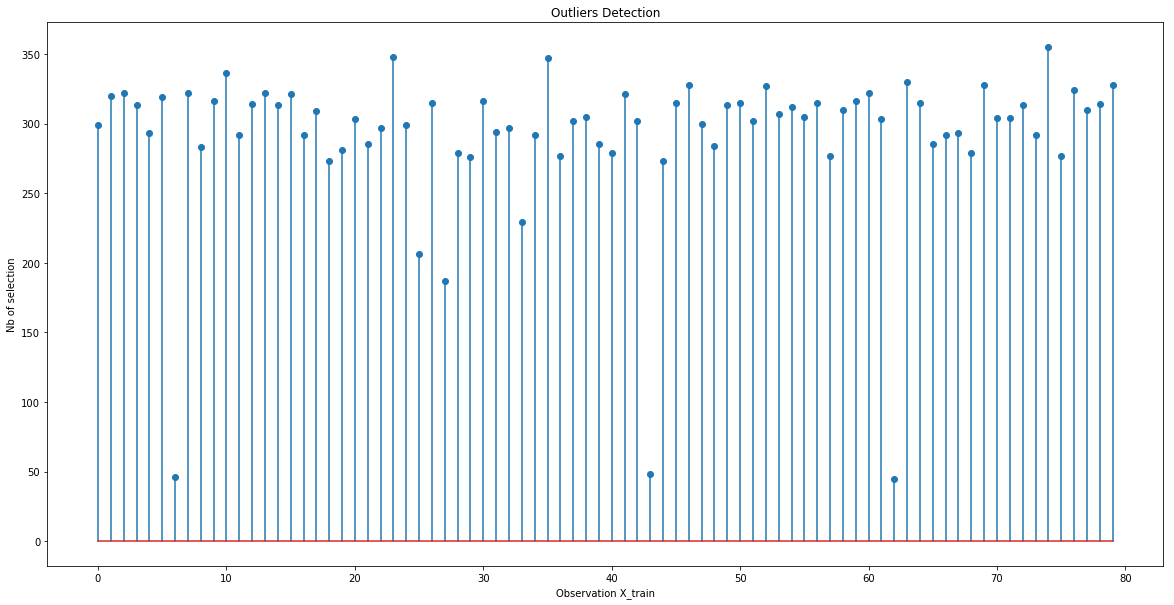

In [17]:
plt.figure(figsize=(20,10))
plt.stem(np.arange(int(0.8*n_sample)),mom_ista[4])
plt.xlabel('Observation X_train')
plt.ylabel('Nb of selection')
plt.title('Outliers Detection')

## Comparizon new blocks at each iteration

In this section we compare two possible algorithm. Note that since the begining we compute new blocks at each iteration of the algorithm. An other strategy would be to keep the same blocks during the algorithm. It turns out that the first idea is much more efficient as it is presented below. 

In [17]:
def MOM_ista_same_block(X, y, t0, t0_prime, step, K, n_iter=50, t_true = coeffs, verbose=True):
    """Alternating Gradient Descent Algorithm"""
    
    t = t0.copy()
    t_prime = t0_prime.copy()
      
    n_samples, n_features = X.shape
    
    errors = np.zeros(n_iter)
    objectives = np.zeros(n_iter)
    
    errors[0] = norm(t - t_true) / norm(t_true)
    X_block, y_block = median_block(X, y, t, t_true, K, X.shape[0])
    objectives[0] = excess_loss(X_block, y_block, t, t_true)
    if verbose:
        print ("Lauching MOM solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
        
    for k in range(1, n_iter ):
        
        
        "Ascent in t_prime"
        
        t_prime = t_prime - step * grad_logreg(X_block, y_block, t_prime)
        
        "Descent in t"
        
        t = t - step * grad_logreg(X_block, y_block, t)
        
        
        "Compute the error and the objective"
        
        errors[k] = norm(t - t_true) / norm(t_true)
        objectives[k] = excess_loss(X_block, y_block, t, t_true)

        if k % 20 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % objectives[k]).rjust(8), 
                              ("%.2e" % errors[k]).rjust(8)]))
            
    return t, t_prime, objectives, errors


def prediction_mom(coeff, X_test, y_test,verbose = True):
    proba = 1/(1+np.exp(-np.dot(X_test, coeff)))
    predictions = np.sign(2*proba-1)
    score = metrics.accuracy_score(y_test,predictions)
    if verbose:
        print("Accuracy for MOM Logistic regression: ", score)
    return(score)

In [18]:
n_sample = 1000
p = 50
coeffs = 10*np.random.uniform(size = p) - 5

y, X = simu_noisy_logistic(coeffs,n_sample)

n_train = int(0.8*n_sample)
X_train = X[0:n_train,:]
y_train = y[0:n_train]

X_test = X[n_train:,:]
y_test = y[n_train:]


log = linear_model.LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)

score = metrics.accuracy_score(y_test,predictions)
print('Accuracy sklearn:', round(score,4)*100)

t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 2000
step = 1. / lip_logreg(X,X_train.shape[0])
K = 50

mom_ista_same_block = MOM_ista_same_block(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=False)
mom_ista_diff_block= MOM_ista(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=False)

print('Prediction same blocks : ')
prediction_mom(mom_ista_same_block[0],X_test,y_test)
print('Prediction new blocks : ')
prediction_mom(mom_ista_diff_block[0],X_test,y_test)

Accuracy sklearn: 93.0
Prediction same blocks : 
Accuracy for MOM Logistic regression:  0.715
Prediction new blocks : 
Accuracy for MOM Logistic regression:  0.9


0.90000000000000002

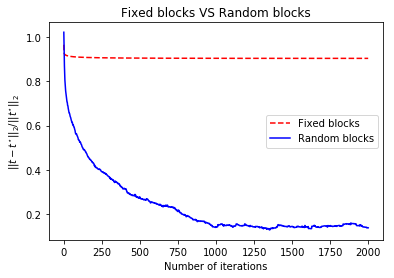

In [72]:
p1 = plt.plot(mom_ista_same_block[3],'r--',label = "Fixed blocks")
p1 = plt.plot(mom_ista_diff_block[3],color = 'blue',label = "Random blocks")
plt.xlabel("Number of iterations")
plt.ylabel('$||t-t^{\star}||_2/||t^{\star}||_2$')
plt.title("Fixed blocks VS Random blocks")
plt.legend()

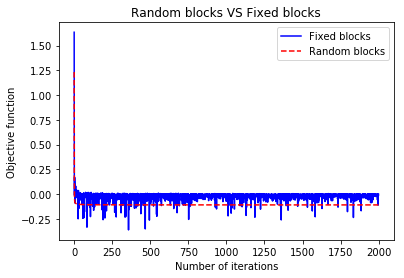

In [73]:
p1 = plt.plot(mom_ista_diff_block[2],color = 'blue',label = "Fixed blocks")
p1 = plt.plot(mom_ista_same_block[2],'r--',label = "Random blocks")
plt.xlabel("Number of iterations")
plt.ylabel('Objective function')
plt.title("Random blocks VS Fixed blocks")
plt.legend()

<Container object of 3 artists>

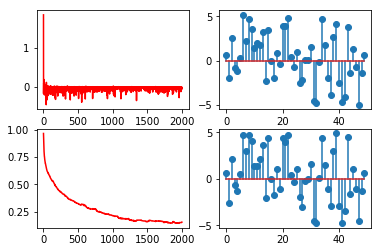

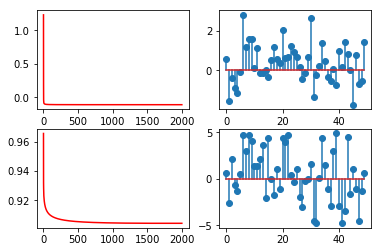

In [21]:
f, axarr = plt.subplots(2,2)
plt.figure(figsize=(8,10))
axarr[0,0].plot(mom_ista_diff_block[2], 'r-', label= 'ISTA')
axarr[1,0].plot(mom_ista_diff_block[3], 'r-', label= 'ISTA')
axarr[0,1].stem(mom_ista_diff_block[0])
axarr[1,1].stem(coeffs)

f, axarr = plt.subplots(2,2)
plt.figure(figsize=(8,10))
axarr[0,0].plot(mom_ista_same_block[2], 'r-', label= 'ISTA')
axarr[1,0].plot(mom_ista_same_block[3], 'r-', label= 'ISTA')
axarr[0,1].stem(mom_ista_same_block[0])
axarr[1,1].stem(coeffs)



## Running time comparizon

In this section we present to computational advantage of the MOM algorithm with respect to a standard method. Since the descent is only performed on a few number of data we expect the MOM algorithm to be faster. 

In [41]:
def Gradient_descent(X, y, t0, step, n_iter=50, t_true = coeffs, verbose=True):
    """Alternating Gradient Descent Algorithm"""
    
    t = t0.copy()

    n_samples, n_features = X.shape
    
    run_time = np.zeros(n_iter)
    errors = np.zeros(n_iter)
    objectives = np.zeros(n_iter)
    
    tmps1=time.clock()
    
    errors[0] = norm(t - t_true) / norm(t_true)
    objectives[0] = excess_loss(X, y, t, t_true)
    
    tmps2=time.clock()
    
    run_time[0] = tmps2- tmps1 
    if verbose:
        print ("Lauching MOM solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
        
    for k in range(1, n_iter ):

        t = t - step * grad_logreg(X, y, t)
        
        
        errors[k] = norm(t - t_true) / norm(t_true)
        objectives[k] = excess_loss(X, y, t, t_true)

        tmps2=time.clock() 
        
        run_time[k] = tmps2- tmps1 
        if k % 20 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % objectives[k]).rjust(8), 
                              ("%.2e" % errors[k]).rjust(8)]))
            
    return t, objectives, errors, run_time

In [42]:
def MOM_ista_time(X, y, t0, t0_prime, step, K, n_iter=50, t_true = coeffs, verbose=True):
    """Alternating Gradient Descent Algorithm"""
    
    t = t0.copy()
    t_prime = t0_prime.copy()
      
    n_samples, n_features = X.shape
    
    run_time = np.zeros(n_iter)
    errors = np.zeros(n_iter)
    objectives = np.zeros(n_iter)
    
    tmps1=time.clock()
    
    errors[0] = norm(t - t_true) / norm(t_true)
    X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
    objectives[0] = excess_loss(X_block, y_block, t, t_true)
    
    tmps2=time.clock()
    
    run_time[0] = tmps2- tmps1
    if verbose:
        print ("Lauching MOM solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
        
    for k in range(1, n_iter ):
        
        "Ascent in t_prime"
        X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
        
        t_prime = t_prime - step * grad_logreg(X_block, y_block, t_prime)
        
        "Descent in t"
        X_block, y_block = median_block(X, y, t, t_prime, K, X.shape[0])
        
        t = t - step * grad_logreg(X_block, y_block, t)
        
        
        "Compute the error and the objective"
        
        errors[k] = norm(t - t_true) / norm(t_true)
        objectives[k] = excess_loss(X_block, y_block, t, t_true)

        tmps2=time.clock() 
        
        run_time[k] = tmps2- tmps1 
        if k % 20 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % objectives[k]).rjust(8), 
                              ("%.2e" % errors[k]).rjust(8)]))
            
    return t, t_prime, objectives, errors, run_time

In [66]:
n_sample = 1000
p = 50
coeffs = 10*np.random.uniform(size = p) - 5

y_train, X_train = simu_logistic(coeffs,n_sample)
print("X shape: ",X.shape)
print("y shape: ",y.shape)

t0 = np.random.random(p)
t0_prime = np.random.random(p)
n_iter = 1000
step = 1. / lip_logreg(X,X_train.shape[0])
K = 50


mom = MOM_ista_time(X=X_train, y=y_train, t0=t0, t0_prime= t0_prime, step =step,
                    K=K, n_iter=n_iter, t_true = coeffs, verbose=False)
Grad_desc = Gradient_descent(X_train, y_train, t0, step, n_iter,coeffs, False)

X shape:  (1000, 50)
y shape:  (1000,)


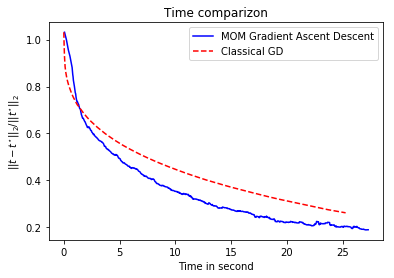

In [71]:
p1 = plt.plot(mom[4],mom[3], color = 'blue',label = "MOM Gradient Ascent Descent")
p1 = plt.plot(Grad_desc[3],Grad_desc[2],'r--',label = "Classical GD")
plt.xlabel("Time in second")
plt.ylabel('$||t-t^{\star}||_2/||t^{\star}||_2$')
plt.title("Time comparizon")
plt.legend()